# Risk Premia Portfolio Backtest

In this notebook we backtest a couple of classic long-only risk premia harvesting strategies:

1. Dollar weighted
2. Inverse volatility weighted

We then optimise the trade buffer parameter for out favoured strategy.

Rebalancing in both strategies occurs ad-hoc when the asset weights exceed the target weights by a margin greater than the 'trade buffer'.

Capital is re-invested using the square root of profits money manager.

A minimum fixed commission per trade is modelled. In this scheme trading back to the ideal target weight is recommended. Contrast with a percentage commission scheme where trading back to the trade buffer limit is considered optimal.

In [21]:
import sys
import os
from pathlib import PurePath
sys.path.append(str(PurePath(os.getcwd()).parent))

import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(
    rc={"figure.figsize":(15, 5)},
    style="darkgrid")

import alphasim.backtest as bt
import alphasim.commission as cmn
import alphasim.money as mo
from alphasim.util import like
import alphasim.stats as stats

%matplotlib inline
%reload_ext autoreload
%autoreload 3

In [22]:
benchmark_ticker = ['SPY']
benchmark_price_df = pdr.get_data_yahoo(benchmark_ticker, start='2005-01-01').dropna()['Adj Close']
benchmark_ret_df = benchmark_price_df.div(benchmark_price_df.shift(1)).apply(np.log)

<AxesSubplot: xlabel='Date'>

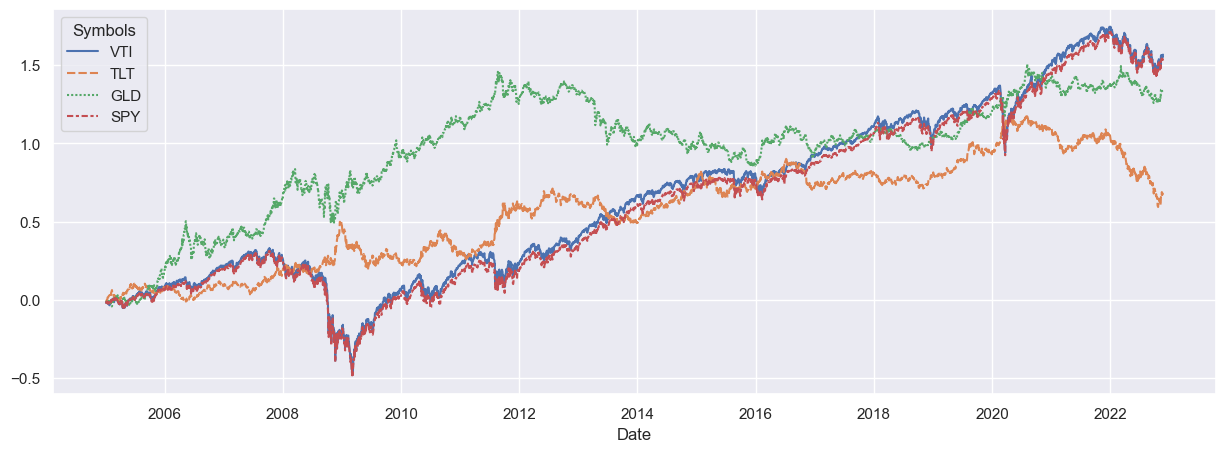

In [23]:
tickers = ['VTI', 'TLT', 'GLD']
ticker_n = len(tickers)
price_df = pdr.get_data_yahoo(tickers, start='2005-01-01').dropna()['Adj Close']
logret_df = price_df.div(price_df.shift(1)).apply(np.log)
sns.lineplot(data=pd.concat([logret_df.cumsum(),benchmark_ret_df.cumsum()]))

## Dollar Weights

Define equal dollar weights for our portfolio.

In [24]:
dollar_weight_df = like(price_df)
dollar_weight_df[:] = [0.333, 0.333, 0.333]

## Inverse Volatility Weights

Define weights based on a rolling volatility measure.

In [25]:
def calc_invol_weight(cov_mat):
    vol = np.sqrt(np.diagonal(cov_mat))
    invol = 1 / vol
    wt = invol / np.sum(invol)
    return wt

/var/folders/g8/cr0p80215nbcfxwt3ppj6cvh0000gn/T/ipykernel_80821/1185675981.py:3: RuntimeWarning: divide by zero encountered in divide
  invol = 1 / vol
/var/folders/g8/cr0p80215nbcfxwt3ppj6cvh0000gn/T/ipykernel_80821/1185675981.py:4: RuntimeWarning: invalid value encountered in divide
  wt = invol / np.sum(invol)


<AxesSubplot: xlabel='Date'>

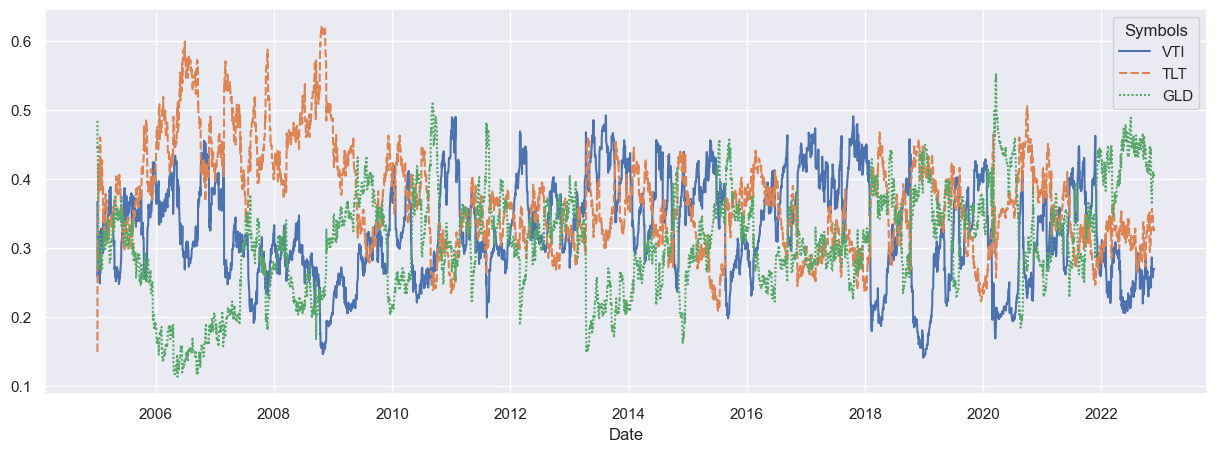

In [26]:
cov_mat = (
    logret_df
    .ewm(alpha=1-0.94)
    .cov()
    .groupby(axis=0, level=0)
    .apply(lambda x: x.fillna(0).values)
)
invol_weight_df = like(logret_df)
invol_weight_df[:] = [calc_invol_weight(x) for x in cov_mat]

sns.lineplot(data=invol_weight_df)

## Backtest

In [27]:
# Define a simple fixed minimum commission scheme whereby every trade costs 10 of the quote currency
def commission(trade_size, trade_value):
    return cmn.fixed_commission(trade_size, trade_value, 10)

In [28]:
# Execute our backtest for the dollar weighted strategy
dw_result_df = bt.backtest(
    prices=price_df.copy(), 
    weights=dollar_weight_df.copy(),
    trade_buffer=0.05, 
    do_trade_to_buffer=False, 
    commission_func=commission,
    initial_capital=10000,
    money_func=mo.sqrt_profit)

In [29]:
# Align the length of prices and weights
price_df = price_df.align(invol_weight_df, axis=0, join='inner')[0]

# Execute our backtest for the ERC strategy
invol_result_df = bt.backtest(
    prices=price_df.copy(), 
    weights=invol_weight_df.copy(),
    trade_buffer=0.05, 
    do_trade_to_buffer=False, 
    commission_func=commission,
    initial_capital=10000,
    money_func=mo.sqrt_profit)

In [30]:
# Compare performance stats
dw_stat_df = stats.calc_stats(dw_result_df)
invol_stat_df = stats.calc_stats(invol_result_df)
display(pd.concat([dw_stat_df, invol_stat_df], keys=["dollar_weighted", "invol_weighted"], axis=1))

,dollar_weighted,invol_weighted
,result,result
start,2005-01-03 00:00:00,2005-01-03 00:00:00
end,2022-11-23 00:00:00,2022-11-23 00:00:00
trading_days_year,252,252
initial,10000.0,10000.0
final,28677.3601,23212.305966
profit,18677.3601,13212.305966
cagr,0.041475,0.033016
ann_volatility,0.071723,0.067577
ann_sharpe,0.578262,0.488568


<AxesSubplot: xlabel='Date'>

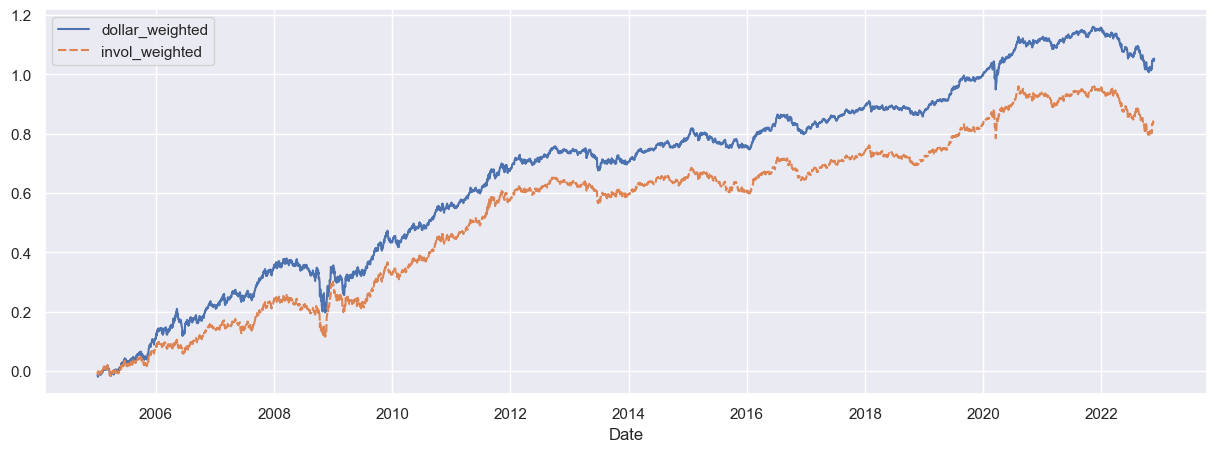

In [36]:
cumsum_df = pd.concat([
    stats.calc_log_returns(dw_result_df).cumsum(),
    stats.calc_log_returns(invol_result_df).cumsum()
], keys=["dollar_weighted", "invol_weighted"], axis = 1)

sns.lineplot(data=cumsum_df)

<AxesSubplot: xlabel='Date'>

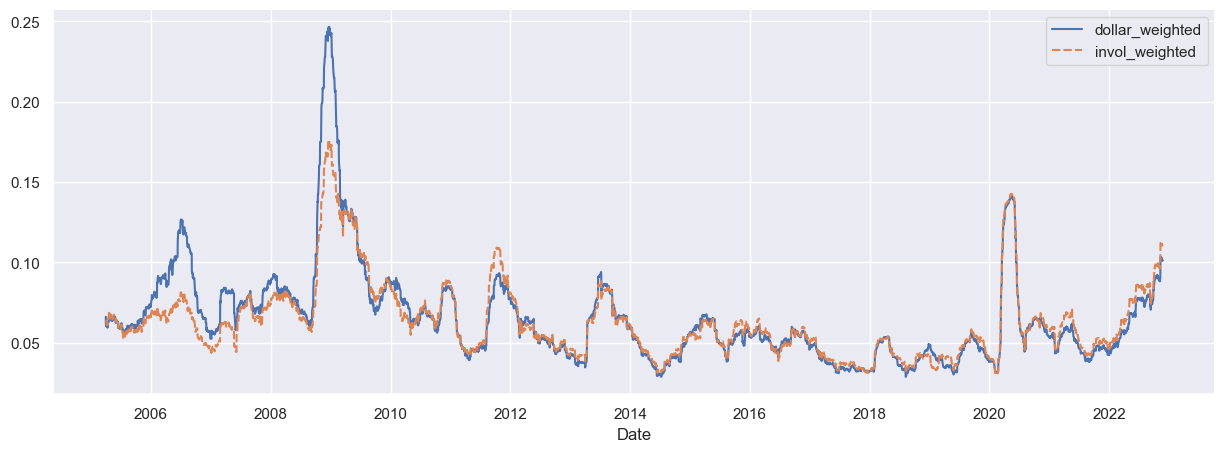

In [37]:
vol_df = pd.concat([
    stats.calc_log_returns(dw_result_df).rolling(window=60).std() * np.sqrt(252),
    stats.calc_log_returns(invol_result_df).rolling(window=60).std() * np.sqrt(252),
], keys=["dollar_weighted", "invol_weighted"], axis = 1)

sns.lineplot(data=vol_df)

## Choosing a strategy

Despite the drag on profit from the extra trading costs, the inverse volatility strategy enjoys lower volatility.

In the next step we will optimise the trade buffer to reduce portfolio turnover.

## Optimsing trade buffer

Analysing the trade buffer by risk-adjusted returns indicates a buffer of 10% would give optimal returns.

In [38]:
price_df = price_df.align(invol_weight_df, axis=0, join='inner')[0]

trade_buffers = [0, 0.02, 0.04, 0.06, 0.08, 0.1]

sharpes = np.array([])

for tb in trade_buffers:

    df = bt.backtest(
        prices=price_df.copy(), 
        weights=invol_weight_df.copy(),
        trade_buffer=tb, 
        do_trade_to_buffer=False, 
        commission_func=commission,
        initial_capital=10000,
        money_func=mo.sqrt_profit)

    sharpes = np.append(sharpes, [stats.calc_stats(df).T["ann_sharpe"]])

,trade_buffer,sharpe
0,0.00,-0.8073
1,0.02,-0.267569
2,0.04,0.395455
3,0.06,0.539902
4,0.08,0.591018
5,0.10,0.616334


<AxesSubplot: xlabel='trade_buffer', ylabel='sharpe'>

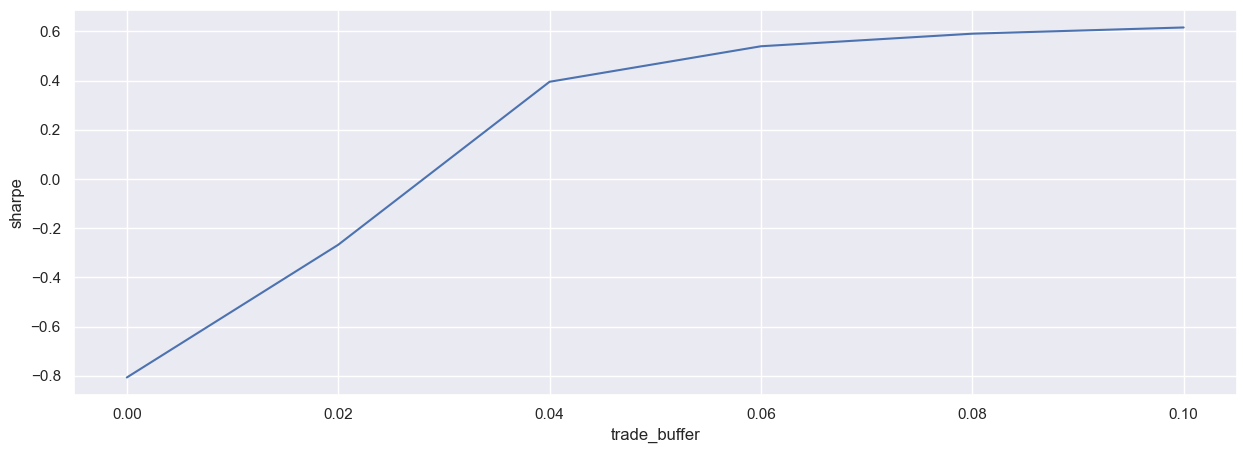

In [39]:
result_df = pd.DataFrame()
result_df["trade_buffer"] = trade_buffers
result_df["sharpe"] = sharpes
display(result_df)

sns.lineplot(data=result_df, x="trade_buffer", y="sharpe")

In [40]:
optima_idx = result_df["sharpe"].astype(np.float64).idxmax()
optima_buffer = result_df["trade_buffer"].iloc[optima_idx]
optima_buffer = float(f"{optima_buffer:.4f}")
display(optima_buffer)

0.1

In [41]:
result_df = bt.backtest(
    prices=price_df.copy(), 
    weights=invol_weight_df.copy(),
    trade_buffer=optima_buffer, 
    do_trade_to_buffer=False, 
    commission_func=commission,
    initial_capital=10000,
    money_func=mo.sqrt_profit)

An improved sharpe and CAGR is clear when comparing the optima and original ERC strategy.

In [42]:
optima_stat_df = stats.calc_stats(result_df)
display(pd.concat([optima_stat_df, invol_stat_df], keys=["optima", "original_invol"], axis=1))

,optima,original_invol
,result,result
start,2005-01-03 00:00:00,2005-01-03 00:00:00
end,2022-11-23 00:00:00,2022-11-23 00:00:00
trading_days_year,252,252
initial,10000.0,10000.0
final,27831.565886,23212.305966
profit,17831.565886,13212.305966
cagr,0.040273,0.033016
ann_volatility,0.065343,0.067577
ann_sharpe,0.616334,0.488568


<AxesSubplot: xlabel='Date'>

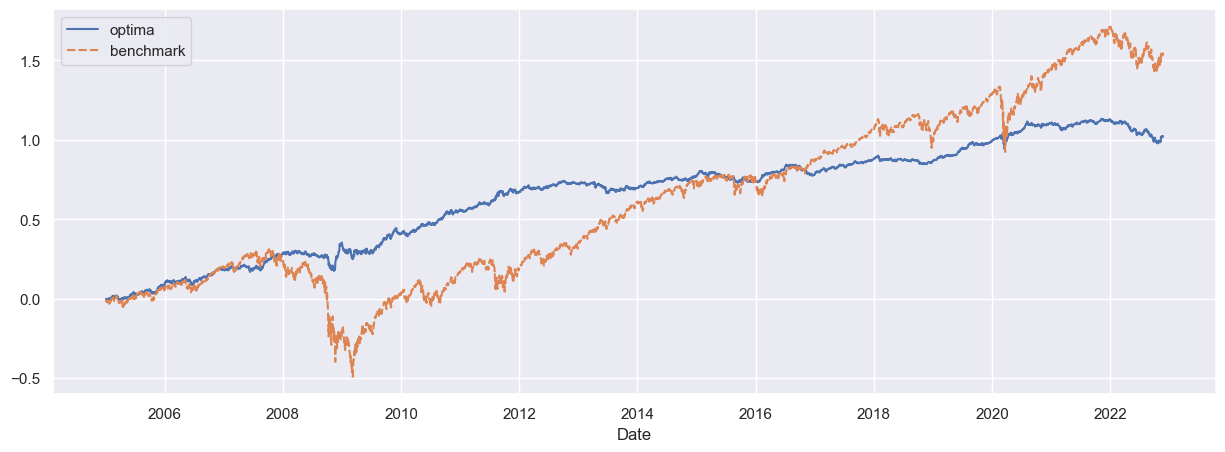

In [47]:
sns.lineplot(data=pd.concat(
    [stats.calc_log_returns(result_df).cumsum(), benchmark_ret_df.cumsum()], 
    keys=["optima", "benchmark"], 
    axis=1))

Note the large rebalances indicated by the right angle change in assets weights. A smaller trade buffer would result in more frequent trades and less abrupt changes in portfolio weights, but at the expense of risk-adjusted returns in this case.

<AxesSubplot: xlabel='Date'>

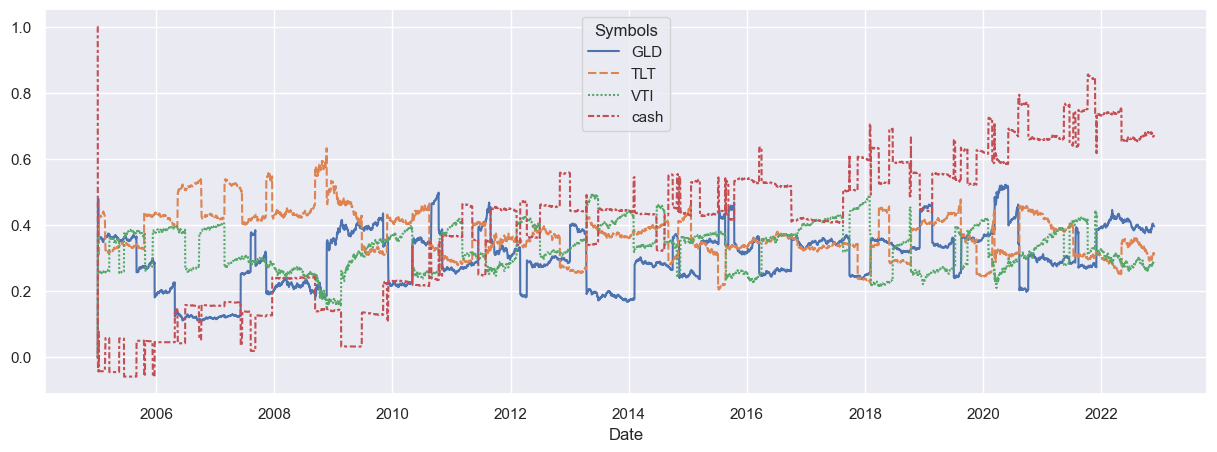

In [45]:
ticker_weight_df = result_df["start_weight"].unstack()
sns.lineplot(data=ticker_weight_df)